In [1]:
!nvidia-smi

Mon Aug 17 17:59:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   31C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import dependencies

In [2]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

import warnings

import utils
import torch_utils
from beam_utils import Node, find_best_path

In [3]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Load & clean data

In [4]:
%%time
data_fr = utils.read_file('./data/europarl-v7.fr-en.fr')
data_en = utils.read_file('./data/europarl-v7.fr-en.en')

assert len(data_fr) == len(data_en)

indexes = np.random.choice(range(len(data_fr)), size=200_000, replace=False)

pairs = [*zip(
    utils.clean_lines([data_fr[index] for index in indexes]),
    utils.clean_lines([data_en[index] for index in indexes])
)]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

100%|██████████| 200000/200000 [00:09<00:00, 20813.01it/s]


Number of examples after sampling: 200,000
Example:
	FR => par ecrit en les conservateurs saluent lobjectif general vise par lamelioration des droits des passagers et de lacces pour les personnes handicapees et par la creation de regles equitables pour les utilisateurs de bus internationaux cest pourquoi jai vote en faveur du rapport
	EN => in writing conservatives welcome the overall aim of improving passenger rights access for the disabled and creating a level playing field for international bus users and for this reason voted in favour of the report
CPU times: user 22.6 s, sys: 1.19 s, total: 23.8 s
Wall time: 23.8 s


## Build datasets

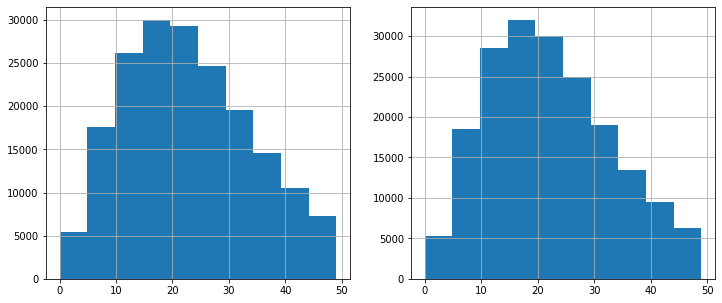

In [5]:
len_fr = [*map(lambda pair: len(pair['fr'].split()), pairs)]
len_en = [*map(lambda pair: len(pair['en'].split()), pairs)]

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist([*filter(lambda x: x < 50, len_fr)])
axes[0].grid(True)
axes[1].hist([*filter(lambda x: x < 50, len_en)])
axes[1].grid(True)
plt.show()

In [7]:
%%time
MIN_LENGTH, MAX_LENGTH = 15, 20
pairs = [*filter(lambda pair: MIN_LENGTH <= len(pair['fr'].split()) <= MAX_LENGTH and MIN_LENGTH <= len(pair['fr'].split()) <= MAX_LENGTH, pairs)]
print(f'Number of examples after filtering: {len(pairs):,}')

Number of examples after filtering: 35,936
CPU times: user 196 ms, sys: 3.95 ms, total: 200 ms
Wall time: 199 ms


In [8]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True)
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en',
           include_lengths=True)

examples = [Example.fromdict(
    data=pair,
    fields={
        'fr': ('src', FR),
        'en': ('dest', EN)
    }
) for pair in tqdm.tqdm(pairs)]
print(f'Number of examples: {len(examples):,}')

100%|██████████| 35936/35936 [00:12<00:00, 2801.85it/s]

Number of examples: 35,936


In [11]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.95, 0.05, 0.05])
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 32,514
valid set size: 1,711
test set size: 1,711
{'src': ['jai', 'suggere', 'la', 'creation', 'dune', 'communaute', 'parmi', 'ces', 'pays', 'afin', 'de', 'renforcer', 'les', 'relations', 'dans', 'le', 'voisinage', 'politique'], 'dest': ['i', 'suggested', 'the', 'creation', 'of', 'a', 'commonwealth', 'among', 'these', 'countries', 'in', 'order', 'to', 'strengthen', 'relations', 'in', 'the', 'political', 'neighbourhood']}


## Build vocabularies

In [12]:
%%time
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 7,396
Length of EN vocabulary: 5,881
CPU times: user 534 ms, sys: 18 µs, total: 534 ms
Wall time: 533 ms


## Modeling

### Encoder model

In [13]:
class EncoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(EncoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, 2 * hidden_size]
            hn: Tensor[n_layers * 2, batch_size, hidden_size]
            cn: Tensor[n_layers * 2, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = F.dropout(embedded, p=self.dropout)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn, cn

In [14]:
def test_encoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.35,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        outputs, hn, cn = encoder(
            input_sequences=data.src[0],
            sequence_lengths=data.src[1]
        )
        seq_len = data.src[0].size(0)
        assert outputs.size() == torch.Size([seq_len, batch_size, 2 * 256]), outputs.size()
        assert hn.size() == torch.Size([4 * 2, batch_size, 256]), hn.size()
        assert cn.size() == torch.Size([4 * 2, batch_size, 256]), cn.size()
        break
    
test_encoder()

### Decoder model

In [15]:
class DecoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(DecoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
        
    def forward(self, input_word_index, h_state, c_state):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        logit = self.fc(F.dropout(outputs, p=self.dropout))
        logit = logit.squeeze(0)
        return logit, h_state, c_state

In [16]:
def test_decoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        logit, h_state, c_state = decoder(
            input_word_index=data.dest[0][0],
            h_state=torch.rand(4, batch_size, 256),
            c_state=torch.rand(4, batch_size, 256)
        )
        assert logit.size() == torch.Size([batch_size, len(EN.vocab)]), logit.size()
        assert h_state.size() == torch.Size([4, batch_size, 256]), h_state.size()
        assert c_state.size() == torch.Size([4, batch_size, 256]), c_state.size()
        break
        
test_decoder()

### Sequence-to-sequence model

In [17]:
class SeqToSeqLSTM(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
            'Encoder and Decoder must have the same number of reccurrent hidden units'
        
        super(SeqToSeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.init_h0 = nn.Linear(decoder.n_layers * 2, decoder.n_layers) 
        self.init_c0 = nn.Linear(decoder.n_layers * 2, decoder.n_layers)
        self.device = device
        
    def forward(self, src_sequences, src_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        :params
            src_sequences: Tensor[seq_len, batch_size]
            src_lengths: Tensor[batch_size,]
            dest_sequences: Tensor[seq_len, batch_size]
            dest_lengths: Tensor[batch_size,]
            tf_ratio: float
            
        :return
            logits: Tensor[max(decode_lengths), batch_size, vocab_size]
            sorted_dest_sequences: Tensor[seq_len, batch_size]
            sorted_decode_lengths: Tensor[batch_size,]
            sorted_indices: Tensor[batch_size,]
        """
        # Encoding
        _, h_state, c_state = self.encoder(
            input_sequences=src_sequences,
            sequence_lengths=src_lengths
        )
        # h_state: [n_layers * 2, batch_size, hidden_size]
        # c_state: [n_layers * 2, batch_size, hidden_size]
        
        # Sort the batch (dest) by decreasing lengths
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        h_state = h_state[:, sorted_indices, :]
        c_state = c_state[:, sorted_indices, :]
        
        # Init hidden and memory states
        h_state = self.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        c_state = self.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist()
        
        # Decoding
        batch_size, last = dest_sequences.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if random.random() < tf_ratio:
                    in_ = last[:batch_size_t]
                else:
                    in_ = sorted_dest_sequences[t, :batch_size_t]
            else:
                in_ = sorted_dest_sequences[t, :batch_size_t]
            # in_ [batch_size,]
            logit, h_state, c_state = self.decoder(
                in_, 
                h_state[:, :batch_size_t, :].contiguous(),
                c_state[:, :batch_size_t, :].contiguous()
            )
            # logit: [batch_size, vocab_size]
            # h_state: [num_layers, batch_size, hidden_size]
            # c_state: [num_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        
        return logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices

In [18]:
def test_seq2seq():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    model = SeqToSeqLSTM(encoder, decoder, device='cpu')
    for data in train_iterator:
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(
                src_sequences=data.src[0], 
                src_lengths=data.src[1],
                dest_sequences=data.dest[0],
                dest_lengths=data.dest[1],
                tf_ratio=0.
            )
        assert logits.size() == torch.Size([
            max(sorted_decode_lengths),
            batch_size,
            len(EN.vocab)
        ]), logits.size()
        assert sorted_dest_sequences.size() == torch.Size([
            data.dest[0].shape[0],
            batch_size
        ]), sorted_dest_sequences.size()
        assert len(sorted_decode_lengths) == batch_size, len(sorted_decode_lengths)
        assert sorted_indices.size() == torch.Size([
            batch_size,
        ]), sorted_indices.size()
        break
        
test_seq2seq()

### Training routines

In [19]:
def train_step(model, optimizer, criterion, loader, epoch, grad_clip, tf_ratio, device):
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.train()
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, data in pbar:
        # Forward prop.
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(*data.src, *data.dest, tf_ratio=tf_ratio)
        # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
        sorted_dest_sequences = sorted_dest_sequences[1:, :]
        # Remove paddings
        logits = nn.utils.rnn.pack_padded_sequence(
            logits,
            sorted_decode_lengths
        ).data
        sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
            sorted_dest_sequences,
            sorted_decode_lengths
        ).data
        # Calculate loss
        loss = criterion(logits, sorted_dest_sequences)
        # Back prop.
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients
        if grad_clip is not None:
            torch_utils.clip_gradient(optimizer, grad_clip)
        # Update weights
        optimizer.step()
        # Track metrics
        loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
        acc_tracker.update(
            torch_utils.accuracy(logits, sorted_dest_sequences, 1),
            sum(sorted_decode_lengths)
        )
        # Update progressbar description
        pbar.set_description(f'Epoch: {epoch + 1:03d} - loss: {loss_tracker.average:.3f} - acc: {acc_tracker.average:.3f}%')
    return loss_tracker.average, acc_tracker.average

In [20]:
def validate(model, criterion, loader, field, epoch, device):
    references, hypotheses = [], []
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar: 
            # Forward prop.
            logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
                model(*data.src, *data.dest, tf_ratio=0.)
            # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            sorted_dest_sequences = sorted_dest_sequences[1:, :]
            # Remove paddings
            logits_copy = logits.clone()
            logits = nn.utils.rnn.pack_padded_sequence(
                logits,
                sorted_decode_lengths
            ).data
            sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
                sorted_dest_sequences,
                sorted_decode_lengths
            ).data
            # Calculate loss
            loss = criterion(logits, sorted_dest_sequences)
            # Track metrics
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(
                torch_utils.accuracy(logits, sorted_dest_sequences, 1),
                sum(sorted_decode_lengths)
            )
            # Update references
            target_sequences = data.dest[0].t()[sorted_indices]
            for j in range(target_sequences.size(0)):
                target_sequence = target_sequences[j].tolist()
                reference = [
                    field.vocab.itos[indice] 
                    for indice in target_sequence 
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ]
                references.append([reference])
            # Update hypotheses
            _, preds = torch.max(logits_copy, dim=2)
            preds = preds.t().tolist()
            for j, p in enumerate(preds):
                hypotheses.append([
                    field.vocab.itos[indice] 
                    for indice in preds[j][:sorted_decode_lengths[j]] # Remove padding
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ])
            assert len(references) == len(hypotheses)
            # Update progressbar description
            pbar.set_description(f'Epoch: {epoch + 1:03d} - val_loss: {loss_tracker.average:.3f} - val_acc: {acc_tracker.average:.3f}%')
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
        # Display some examples
        for i in np.random.choice(len(loader), 3):
            src, dest = ' '.join(references[i][0]), ' '.join(hypotheses[i])
            display(HTML(f'<span style="color:blue"><b>Ground truth translation:</b> {src}</span>'))
            display(HTML(f'<span style="color:red"><b>Predicted translation:</b> {dest}</span>'))
            print('='*100)
    return loss_tracker.average, acc_tracker.average, bleu4

In [21]:
def train(model, optimizer, criterion, train_loader, valid_loader, field, n_epochs, grad_clip, tf_ratio, last_improv, model_name, device):
    history, best_bleu = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
        'bleu4': []
    }, 0.
    for epoch in range(n_epochs):
         # Stop training if no improvment since last 4 epochs
        if last_improv == 4:
            print('Training Finished - The model has stopped improving since last 4 epochs')
            break
        # Decay LR if no improvment
        if last_improv > 0:
            torch_utils.adjust_lr(optimizer=optimizer,
                                  shrink_factor=0.9,
                                  verbose=True)
        # Train step
        loss, acc = train_step(model=model,
                               optimizer=optimizer,
                               criterion=criterion,
                               loader=train_loader,
                               epoch=epoch,
                               grad_clip=grad_clip, 
                               tf_ratio=tf_ratio,
                               device=device)
        # Validation step
        val_loss, val_acc, bleu4 = validate(model=model,
                                            criterion=criterion,
                                            loader=valid_loader,
                                            field=field,
                                            epoch=epoch,
                                            device=device)
        # Update history dict
        history['acc'].append(acc)
        history['loss'].append(loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['bleu4'].append(bleu4)
        # Print BLEU score
        text = f'BLEU-4: {bleu4*100:.3f}%'
        if bleu4 > best_bleu:
            best_bleu, last_improv = bleu4, 0
        else:
            last_improv += 1
            text += f' - Last improvement since {last_improv} epoch(s)'
        print(text)
        # Decrease teacher forcing rate
        tf_ratio = torch_utils.adjust_tf(tf_ratio,
                                         shrink_factor=0.8,
                                         verbose=False)
        # Save checkpoint
        torch_utils.save_checkpoint(model=model,
                                    optimizer=optimizer,
                                    data_name=model_name,
                                    epoch=epoch,
                                    last_improv=last_improv,
                                    bleu4=bleu4,
                                    is_best=bleu4 >= best_bleu)
    return history

### Init models

In [22]:
%%time
# Load word vectors
spacy_fr = spacy.load('fr_core_news_lg') # CBOW trained word vectors
spacy_en = spacy.load('en_core_web_lg') # GloVe trained word vectors

CPU times: user 8.33 s, sys: 1.51 s, total: 9.84 s
Wall time: 9.84 s


In [23]:
# Load embeddings
fr_embeddings = torch_utils.load_embeddings(nlp=spacy_fr, field=FR)
en_embeddings = torch_utils.load_embeddings(nlp=spacy_en, field=EN)

100%|██████████| 5953/5953 [00:59<00:00, 100.26it/s]


In [24]:
MODEL_NAME = 'seq2seq-lstm'
N_LAYERS = 1
HIDDEN_SIZE = 128
EMBEDDING_SIZE = 300
ENC_DROPOUT = 0.25
ENC_RECURRENT_DROPOUT = 0.
DEC_DROPOUT = 0.15
DEC_RECURRENT_DROPOUT = 0.
N_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
GRAD_CLIP = 1.0
TF_RATIO = 1.0

In [25]:
encoder = EncoderLSTM(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(FR.vocab),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=ENC_DROPOUT,
    recurrent_dropout=ENC_RECURRENT_DROPOUT
)
encoder.load_pretrained_embeddings(fr_embeddings)
encoder.fine_tuning_embeddings(fine_tune=True)
decoder = DecoderLSTM(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(EN.vocab),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DEC_DROPOUT,
    recurrent_dropout=DEC_RECURRENT_DROPOUT
)
decoder.load_pretrained_embeddings(en_embeddings)
decoder.fine_tuning_embeddings(fine_tune=True)
seq2seq = SeqToSeqLSTM(encoder=encoder, decoder=decoder, device=DEVICE)
seq2seq.apply(torch_utils.xavier_init_weights)
seq2seq.to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {torch_utils.count_parameters(seq2seq):,}')

Number of parameters of the model: 5,402,235


### Training

In [26]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True,
                              device=DEVICE)

In [27]:
history = train(model=seq2seq,
                optimizer=optimizer,
                criterion=criterion,
                train_loader=train_iterator,
                valid_loader=valid_iterator,
                field=EN,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                tf_ratio=TF_RATIO,
                last_improv=0,
                model_name=MODEL_NAME,
                device=DEVICE)

Epoch: 001 - val_loss: 5.644 - val_acc: 2.607%: 100%|██████████| 27/27 [00:01<00:00, 19.77it/s]


BLEU-4: 0.522%


Epoch: 002 - val_loss: 5.178 - val_acc: 3.753%: 100%|██████████| 27/27 [00:01<00:00, 19.87it/s]


BLEU-4: 1.269%


Epoch: 003 - val_loss: 4.855 - val_acc: 4.502%: 100%|██████████| 27/27 [00:01<00:00, 19.21it/s]


BLEU-4: 2.442%


Epoch: 004 - val_loss: 4.619 - val_acc: 4.946%: 100%|██████████| 27/27 [00:01<00:00, 20.28it/s]


BLEU-4: 3.316%


Epoch: 005 - val_loss: 4.455 - val_acc: 5.231%: 100%|██████████| 27/27 [00:01<00:00, 20.09it/s]


BLEU-4: 3.899%


Epoch: 006 - val_loss: 4.315 - val_acc: 5.507%: 100%|██████████| 27/27 [00:01<00:00, 20.52it/s]


BLEU-4: 4.382%


Epoch: 007 - val_loss: 4.220 - val_acc: 5.667%: 100%|██████████| 27/27 [00:01<00:00, 19.41it/s]


BLEU-4: 4.712%


Epoch: 008 - val_loss: 4.132 - val_acc: 5.857%: 100%|██████████| 27/27 [00:01<00:00, 19.29it/s]


BLEU-4: 5.108%


Epoch: 009 - val_loss: 4.058 - val_acc: 5.971%: 100%|██████████| 27/27 [00:01<00:00, 19.71it/s]


BLEU-4: 5.480%


Epoch: 010 - val_loss: 4.015 - val_acc: 6.049%: 100%|██████████| 27/27 [00:01<00:00, 19.12it/s]


BLEU-4: 5.559%


Epoch: 011 - val_loss: 3.963 - val_acc: 6.227%: 100%|██████████| 27/27 [00:01<00:00, 19.16it/s]


BLEU-4: 5.813%


Epoch: 012 - val_loss: 3.987 - val_acc: 6.041%: 100%|██████████| 27/27 [00:01<00:00, 20.64it/s]


BLEU-4: 5.837%


Epoch: 013 - val_loss: 3.965 - val_acc: 6.171%: 100%|██████████| 27/27 [00:01<00:00, 19.65it/s]


BLEU-4: 6.195%


Epoch: 014 - val_loss: 3.873 - val_acc: 6.393%: 100%|██████████| 27/27 [00:01<00:00, 13.79it/s]


BLEU-4: 6.608%


Epoch: 015 - val_loss: 3.876 - val_acc: 6.372%: 100%|██████████| 27/27 [00:01<00:00, 19.09it/s]


BLEU-4: 6.563% - Last improvement since 1 epoch(s)


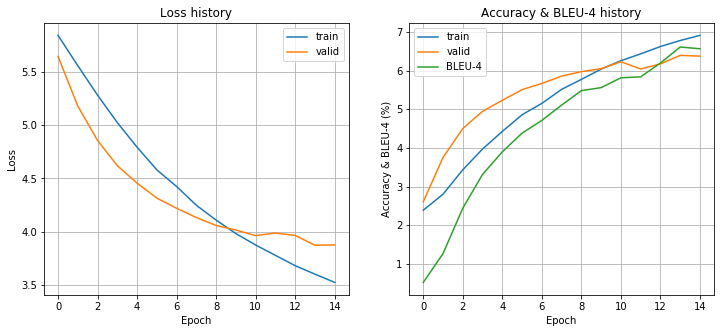

In [28]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(history['acc'], label='train')
axes[1].plot(history['val_acc'], label='valid')
axes[1].plot(np.array(history['bleu4']) * 100., label='BLEU-4')
axes[1].set_title('Accuracy & BLEU-4 history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy & BLEU-4 (%)')
axes[1].grid(True)
axes[1].legend()
plt.show()

### Evaluation with Beam Search

In [29]:
seq2seq.load_state_dict(torch.load(f'./checkpoint/BEST_{MODEL_NAME}.pt').get('model'))

<All keys matched successfully>

In [30]:
def evaluate(model, loader, beam_size, src_field, dest_field, max_len, device):
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar:
            (src_sequences, src_lengths) = data.src[0], data.src[1]
            (dest_sequences, dest_lengths) = data.dest[0], data.dest[1]
            
            batch_size = src_sequences.shape[1]
            for j in range(batch_size): # We evaluate sentence by sentence
                src_sequence = src_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                dest_sequence = dest_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                src_length, dest_length = src_lengths[j, None], dest_lengths[j, None] # [1,]
                
                # Encoding
                _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                    sequence_lengths=src_length)
                
                # Init hidden and memory states
                h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                
                # Decoding
                tree = [[Node(
                    token=torch.LongTensor([
                        dest_field.vocab.stoi[dest_field.init_token]
                    ]).to(device),
                    states=(h_state, c_state)
                )]]
                
                for _ in range(max_len):
                    next_nodes = []
                    for node in tree[-1]:
                        # Skip eos token
                        if node.eos:
                            continue
                        # Decode
                        logit, h_state, c_state = model.decoder(
                            input_word_index=node.token, 
                            h_state=node.states[0].contiguous(),
                            c_state=node.states[1].contiguous()
                        )
                        # logit: [1, vocab_size]
                        # h_state: [n_layers, 1, hidden_size]
                        # c_state: [n_layers, 1, hidden_size]

                        # Get scores
                        logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                        # Get top k tokens & logps
                        topk_logps, topk_tokens = torch.topk(logp, beam_size)

                        for k in range(beam_size):
                            next_nodes.append(Node(
                                token=topk_tokens[k, None],
                                states=(h_state, c_state),
                                logp=topk_logps[k, None].cpu().item(),
                                parent=node,
                                eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]
                            ))
                    
                    if len(next_nodes) == 0:
                        break
                    
                    # Sort next_nodes to get the best
                    next_nodes = sorted(next_nodes,
                                        key=lambda node: node.logps,
                                        reverse=True)
                    # Update the tree
                    tree.append(next_nodes[:beam_size])
                
                # Find the best path of the tree
                best_path = find_best_path(tree)
                
                # Get the translation
                pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
                pred_translated = [*filter(lambda word: word not in [
                    dest_field.init_token, dest_field.eos_token
                ], pred_translated[::-1])]
                
                # Update hypotheses
                hypotheses.append(pred_translated)
                
                # Update references
                references.append([[
                    dest_field.vocab.itos[indice] 
                    for indice in dest_sequence 
                    if indice not in (
                        dest_field.vocab.stoi[dest_field.init_token],
                        dest_field.vocab.stoi[dest_field.eos_token],
                        dest_field.vocab.stoi[dest_field.pad_token]
                    )
                ]])
                
                # Update sources
                sources.append([
                    src_field.vocab.itos[indice] 
                    for indice in src_sequence 
                    if indice not in (
                        src_field.vocab.stoi[src_field.init_token],
                        src_field.vocab.stoi[src_field.eos_token],
                        src_field.vocab.stoi[src_field.pad_token]
                    )
                ])
    
        # Calculate BLEU-4 score
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    
    return hypotheses, references, sources, bleu4

In [31]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
                          loader=test_iterator,
                          beam_size=1,
                          src_field=FR,
                          dest_field=EN,
                          max_len=MAX_LENGTH,
                          device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=1')

100%|██████████| 27/27 [00:36<00:00,  1.37s/it]


BLEU-4: 5.816% with beam_size=1


In [32]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
                          loader=test_iterator,
                          beam_size=5,
                          src_field=FR,
                          dest_field=EN,
                          max_len=MAX_LENGTH,
                          device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=5')

100%|██████████| 27/27 [03:06<00:00,  6.91s/it]


BLEU-4: 6.428% with beam_size=5


In [33]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
                          loader=test_iterator,
                          beam_size=10,
                          src_field=FR,
                          dest_field=EN,
                          max_len=MAX_LENGTH,
                          device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=10')

100%|██████████| 27/27 [08:03<00:00, 17.89s/it]


BLEU-4: 6.333% with beam_size=10


### Inference

In [34]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.dest), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    
    translated_sentences = []
    
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(data), total=len(data))
        for i, (src_sequence, src_length) in pbar:
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
                
            # Encoding
            _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                    sequence_lengths=src_length)
                
            # Init hidden and memory states
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
            c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                
            # Decoding
            tree = [[Node(
                token=torch.LongTensor([
                    dest_field.vocab.stoi[dest_field.init_token]
                ]).to(device),
                states=(h_state, c_state)
            )]]
               
            # Generate tokens
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    # Skip eos token
                    if node.eos:
                        continue
                    # Decode
                    logit, h_state, c_state = model.decoder(
                        input_word_index=node.token, 
                        h_state=node.states[0].contiguous(),
                        c_state=node.states[1].contiguous()
                    )
                    # logit: [1, vocab_size]
                    # h_state: [n_layers, 1, hidden_size]
                    # c_state: [n_layers, 1, hidden_size]

                    # Get scores
                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                    # Get top k tokens & logps
                    topk_logps, topk_tokens = torch.topk(logp, beam_size)

                    for k in range(beam_size):
                        next_nodes.append(Node(
                            token=topk_tokens[k, None],
                            states=(h_state, c_state),
                            logp=topk_logps[k, None].cpu().item(),
                            parent=node,
                            eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]
                        ))
                
                if len(next_nodes) == 0:
                    break

                # Sort next_nodes to get the best
                next_nodes = sorted(next_nodes,
                                    key=lambda node: node.logps,
                                    reverse=True)
                # Update the tree
                tree.append(next_nodes[:beam_size])
                
            # Find the best path of the tree
            best_path = find_best_path(tree)

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated[::-1])]
                
            translated_sentences.append(' '.join(pred_translated))
            
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets

In [35]:
sentences, translated_sentences, dest_sentences = translate(sentences=test_data,
                                                            model=seq2seq,
                                                            beam_size=5,
                                                            src_field=FR,
                                                            dest_field=EN,
                                                            max_len=MAX_LENGTH,
                                                            device=DEVICE)

indexes = np.random.choice(len(test_data.examples), size=20, replace=False)
print(indexes)
print()
for i in indexes:
    display(HTML(f'<span style="color:blue"><b>Source:</b> {sentences[i]}</span>'))
    display(HTML(f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span>'))
    display(HTML(f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span>'))
    print('='*100)

100%|██████████| 1711/1711 [02:56<00:00,  9.67it/s]

[ 969  658  320  352  792  183  279  578  476  421   64 1339 1576  228
 1681  515  922   25 1640 1342]

